In [70]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [79]:
## Mobileinsight csv file~
file = '/home/wmnlab/Work/sheng-ru/2022-09-07/mi2log/diag_log_sm08_2022-09-07_17-25-35.mi2log.txt_rrc.csv'
mi_rrc_df = pd.read_csv(file)
mi_rrc_df["time"].iloc[:] = pd.to_datetime(mi_rrc_df["time"].iloc[:]) + dt.timedelta(hours=8)

file2 = '~/diag_log_sm08_2022-09-07_17-49-24.mi2log.txt_ml1_new.csv'
mi_ml1_df = pd.read_csv(file2)
mi_ml1_df = mi_ml1_df[mi_ml1_df.type_id == 'LTE_PHY_Connected_Mode_Intra_Freq_Meas']
mi_ml1_df["time"].iloc[:] = pd.to_datetime(mi_ml1_df["time"].iloc[:]) + dt.timedelta(hours=8)

file3 = '~/diag_log_sm08_2022-09-07_17-49-24.mi2log.txt_nr_ml1_new.csv'
mi_nr_ml1_df = pd.read_csv(file3)

mi_nr_ml1_df["time"].iloc[:] = pd.to_datetime(mi_nr_ml1_df["time"].iloc[:]) + dt.timedelta(hours=8)

/tmp/ipykernel_4030/3034838573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_rrc_df["time"].iloc[:] = pd.to_datetime(mi_rrc_df["time"].iloc[:]) + dt.timedelta(hours=8)
/tmp/ipykernel_4030/3034838573.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_nr_ml1_df["time"].iloc[:] = pd.to_datetime(mi_nr_ml1_df["time"].iloc[:]) + dt.timedelta(hours=8)


# LTE Signal Strength

In [80]:
class data_point:
    def __init__(self, pd_data): ## Input pd_df.iloc[index]
        self.time = pd_data['time']
        self.pci = pd_data['PCI']
        self.servingcell = pd_data['Serving Cell Index']
        self.earfcn = pd_data['EARFCN']
        self.RSRPQ = float(pd_data['RSRP(dBm)']), float(pd_data['RSRQ(dB)'])
        self.neighbor = self.get_nei_pci_signal_strength(pd_data)

    def get_nei_pci_signal_strength(self, pd_data):
        nei_cells = {}
        for i in range(9, len(pd_data), 3):
            if pd_data[i] == '-':
                break
            else:
                nei_cells[pd_data[i]] = (float(pd_data[i+1]), float(pd_data[i+2]))                
        return nei_cells

class Signal_Strength_map:
    def __init__(self, mi_ml1_df, mi_rrc_df=None):
        self.L = self.data_list(mi_ml1_df)
        if mi_rrc_df is not None:
            self.ho_event = self.collect_ho_event(mi_rrc_df)
    def data_list(self, mi_ml1_df):
        L = []
        for i in range(len(mi_ml1_df)):
            L.append(data_point(mi_ml1_df.iloc[i]))
        return L

    def draw_pci_rsrp(self, pci_list, x_lim=None, y_lim=None, show_earfcn=False, show_ho=[]): ## Format of l: [('pci1', 'earfcn1'), (pci2, earfcn2), (pci3, earfcn3),...] 
        pci_wanted = [i[0] for i in pci_list]
        earfcn_wanted = [i[1] for i in pci_list]

        if len(pci_list) == 0:
            print("Empty pci list.")
        else:
            x_lists = [] ## Time x = [x1, x2, x3, ...]
            rsrp_lists = [] ## rsrp = [rsrp1, rsrp2, rsrp3, ...]
            for i in range(len(pci_list)):
                x_lists.append([])
                rsrp_lists.append([])

            for i in range(len(self.L)):
                data = self.L[i]
                neighbor_list = list(data.neighbor.keys())
                
                for j in range(len(pci_list)):
                    if data.pci == pci_wanted[j] and data.earfcn == earfcn_wanted[j]:
                        x_lists[j].append(data.time)
                        rsrp_lists[j].append(data.RSRPQ[0])

                    for nei_pci in neighbor_list:
                        if nei_pci == pci_wanted[j] and data.earfcn == earfcn_wanted[j]:
                            x_lists[j].append(data.time)
                            rsrp_lists[j].append(data.neighbor[nei_pci][0])
            
        fig = plt.figure(figsize=(15, 3))
        for i in range(len(x_lists)):
            diff = [(x_lists[i][j+1] - x_lists[i][j]).total_seconds() for j in range(len(x_lists[i])) if j != len(x_lists[i]) -1 ]
            test = 3

            l = []
            for j in range(len(diff)):
                if diff[j] > test: ## If diff > test, no connected
                    l.append(j)
            
            count = 0
            for j in l:
                x_lists[i].insert(j+count+1, x_lists[i][j+count] + dt.timedelta(seconds=test))
                rsrp_lists[i].insert(j+count+1, np.nan)
                count += 1
            
            plt.plot(x_lists[i],rsrp_lists[i])

        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        x_min, x_max = axes.get_xlim()

        colors = ['red', 'green', 'pink', 'cyan', 'lightskyblue']
        if len(show_ho) != 0:
            d = self.ho_event
            i = 0
            for ho in show_ho:
                a = [ i for i in self.ho_event[ho]]
                plt.vlines(a,ymin=y_min, ymax=y_max,label=ho, color=colors[i])
                i += 1

        if show_earfcn:
            legend = [p+' ('+e+')' for p,e in zip(pci_wanted, earfcn_wanted)] 
            plt.legend(legend+show_ho)
        else:
            plt.legend(pci_wanted+show_ho)
            
        if x_lim is not None:
            plt.xlim(x_lim)
        else:
            plt.xlim(x_min, x_max)
        
        if y_lim is not None:
            plt.ylim(y_lim)

        plt.show()

    def collect_ho_event(self, mi_rrc_df):
        lte_handover = []
        both_handover = []
        nr_setup = []
        nr_handover = []

        nr_release = []

        lte_failure = []
        nr_failure = []

        for i in range(len(mi_rrc_df)):

            if mi_rrc_df["type_id"].iloc[i] == "5G_NR_RRC_OTA_Packet": ## We actually don't need 5G_OTA packet under NSA. All we need are in LTE_OTA packet.
                continue

            if mi_rrc_df["lte-rrc.t304"].iloc[i] == 1 and mi_rrc_df["nr-rrc.t304"].iloc[i] == 1: ## 依照NSA的EN-DC架構，分類LTE,NR的HO
                both_handover.append(mi_rrc_df["time"].iloc[i])
            elif mi_rrc_df["lte-rrc.t304"].iloc[i] == 1:
                lte_handover.append(mi_rrc_df["time"].iloc[i])
            elif mi_rrc_df["nr-rrc.t304"].iloc[i] == 1:
                if mi_rrc_df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                    nr_setup.append(mi_rrc_df["time"].iloc[i])
                else:
                    nr_handover.append(mi_rrc_df["time"].iloc[i])
            
            if mi_rrc_df["nr-Config-r15: release (0)"].iloc[i] == 1:
                nr_release.append(mi_rrc_df["time"].iloc[i])

            if mi_rrc_df["rrcConnectionReestablishmentRequest"].iloc[i] == 1: ## 其實還要在分type2和type3
                lte_failure.append(mi_rrc_df["time"].iloc[i])

            if mi_rrc_df["scgFailureInformationNR-r15"].iloc[i] == 1: ## 其實還要再分是否決定重連，重連後是否LTE和NR都重連
                nr_failure.append(mi_rrc_df["time"].iloc[i])

        d = {'lte': lte_handover, 'both': both_handover, 'nr_setup': nr_setup, 'nr': nr_handover, 're_rel': nr_release, 'lte_RLF': lte_failure, 'nr_RLF': nr_failure}
        return d
    
    def draw_ho_event(self, ho_type, x_lim=None):
        fig = plt.figure(figsize=(15, 3))
        colors = ['red', 'green', 'pink', 'cyan', 'lightskyblue']
        i = 0
        for type in ho_type:
            if type in list(self.ho_event.keys()):
                a = self.ho_event[type]
                plt.vlines(a,ymin=0, ymax=1,label=type, color=colors[i])
                i += 1
        
        if x_lim is not None:
            plt.xlim(x_lim)
            
        plt.legend()
        plt.show()

In [81]:
x = Signal_Strength_map(mi_ml1_df, mi_rrc_df)

In [82]:
x.ho_event

{'lte': [Timestamp('2022-09-07 17:29:01.336714'),
  Timestamp('2022-09-07 17:29:03.345367'),
  Timestamp('2022-09-07 17:30:02.639075'),
  Timestamp('2022-09-07 17:30:05.035137'),
  Timestamp('2022-09-07 17:30:10.201605'),
  Timestamp('2022-09-07 17:31:07.206862'),
  Timestamp('2022-09-07 17:32:04.525902'),
  Timestamp('2022-09-07 17:32:04.784051')],
 'both': [Timestamp('2022-09-07 17:28:39.015723'),
  Timestamp('2022-09-07 17:30:13.841612'),
  Timestamp('2022-09-07 17:30:15.896516'),
  Timestamp('2022-09-07 17:30:16.755885'),
  Timestamp('2022-09-07 17:30:18.752650'),
  Timestamp('2022-09-07 17:31:14.381939'),
  Timestamp('2022-09-07 17:31:28.231617'),
  Timestamp('2022-09-07 17:31:46.450444'),
  Timestamp('2022-09-07 17:31:47.419643'),
  Timestamp('2022-09-07 17:31:58.100144'),
  Timestamp('2022-09-07 17:32:00.365049'),
  Timestamp('2022-09-07 17:32:16.314149'),
  Timestamp('2022-09-07 17:32:20.300348')],
 'nr_setup': [Timestamp('2022-09-07 17:25:43.695210'),
  Timestamp('2022-09-07 1

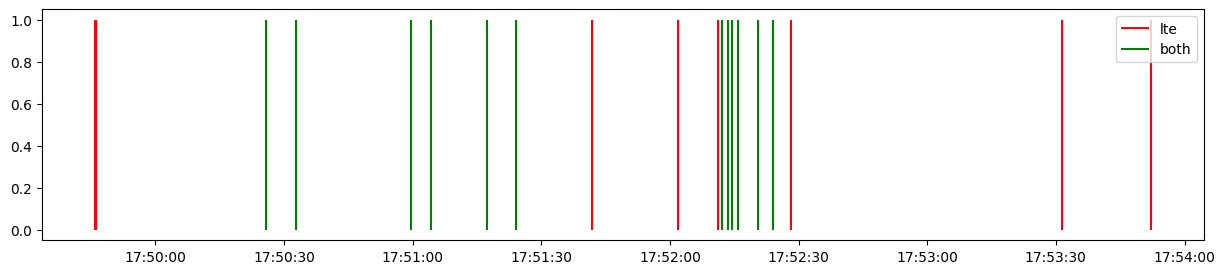

In [14]:
ho_type = ['lte','both']
# time_range = [dt.datetime(2022, 9, 7, 17, 52, 10), dt.datetime(2022, 9, 7, 17, 52, 25)]
time_range = None
x.draw_ho_event(ho_type=ho_type, x_lim=time_range)

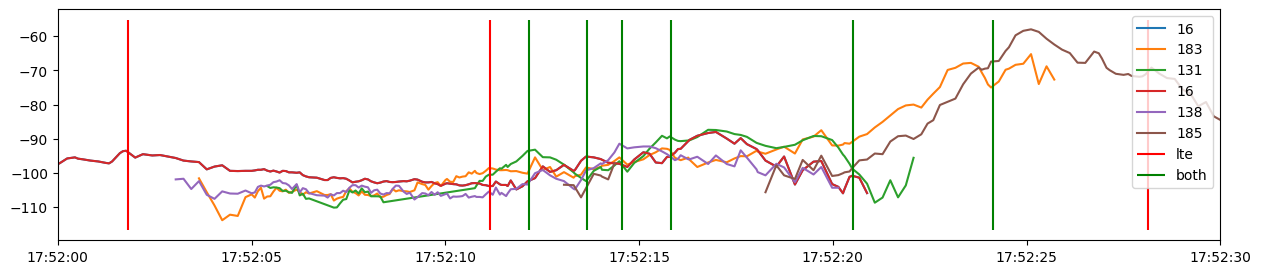

In [15]:
pci_list = [('16','9560'), ('183', '9560'), ('131','9560'),('16','9560'),('138','9560'),('185', '9560')]
time_range = [dt.datetime(2022, 9, 7, 17, 52, 0), dt.datetime(2022, 9, 7, 17, 52, 30)]
# time_range = None
rsrp_range = [-100, -80]
rsrp_range = None
show_ho = ['lte','both']

x.draw_pci_rsrp(pci_list, show_earfcn=False, x_lim=time_range, y_lim=rsrp_range, show_ho=show_ho)

# NR Signal Stremgth

In [16]:
class nr_data_point:
    def __init__(self, pd_data): ## Input pd_df.iloc[index]
        self.time = pd_data['time']
        # self.servingcell_index = pd_data['Serving Cell Index']
        # self.servingcell_index = pd_data['Serving Cell PCI']
        # self.earfcn = pd_data['Raster ARFCN']
        self.neighbor = self.get_nei_pci_signal_strength(pd_data)

    def get_nei_pci_signal_strength(self, pd_data):
        nei_cells = {}
        for i in range(6, len(pd_data), 3):
            if pd_data[i] == '-':
                break
            else:
                if i == 6:
                    nei_cells[str(pd_data[i])] = (float(pd_data[i+1]), float(pd_data[i+2]))
                else:
                    nei_cells[pd_data[i]] = (float(pd_data[i+1]), float(pd_data[i+2]))                
        return nei_cells

class Signal_Strength_map:
    def __init__(self, mi_nr_ml1_df, mi_rrc_df=None):
        self.L = self.data_list(mi_nr_ml1_df)
        if mi_rrc_df is not None:
            self.ho_event = self.collect_ho_event(mi_rrc_df)
    def data_list(self, mi_nr_ml1_df):
        L = []
        for i in range(len(mi_nr_ml1_df)):
            L.append(nr_data_point(mi_nr_ml1_df.iloc[i]))
        return L

    def draw_pci_rsrp(self, pci_list, x_lim=None, y_lim=None, show_ho=[]): ## Format of pci_list: ['pci1', 'pci2', ...] 
        if len(pci_list) == 0:
            print("Empty pci list.")
        else:
            x_lists = [] ## Time x = [x1, x2, x3, ...]
            rsrp_lists = [] ## rsrp = [rsrp1, rsrp2, rsrp3, ...]
            for i in range(len(pci_list)):
                x_lists.append([])
                rsrp_lists.append([])

            for i in range(len(self.L)):
                data = self.L[i]
                neighbor_list = list(data.neighbor.keys())
                
                for j in range(len(pci_list)):
                    for nei_pci in neighbor_list:
                        if nei_pci == pci_list[j]:
                            x_lists[j].append(data.time)
                            rsrp_lists[j].append(data.neighbor[nei_pci][0])
            
        fig = plt.figure(figsize=(15, 3))
        for i in range(len(x_lists)):
            diff = [(x_lists[i][j+1] - x_lists[i][j]).total_seconds() for j in range(len(x_lists[i])) if j != len(x_lists[i]) -1 ]
            test = 3

            l = []
            for j in range(len(diff)):
                if diff[j] > test: ## If diff > test, no connected
                    l.append(j)
            
            count = 0
            for j in l:
                x_lists[i].insert(j+count+1, x_lists[i][j+count] + dt.timedelta(seconds=test))
                rsrp_lists[i].insert(j+count+1, np.nan)
                count += 1
            
            plt.plot(x_lists[i],rsrp_lists[i])

        axes = plt.gca()
        y_min, y_max = axes.get_ylim()
        x_min, x_max = axes.get_xlim()

        colors = ['red', 'green', 'pink', 'cyan', 'lightskyblue']
        if len(show_ho) != 0:
            d = self.ho_event
            i = 0
            for ho in show_ho:
                a = [ i for i in self.ho_event[ho]]
                plt.vlines(a,ymin=y_min, ymax=y_max,label=ho, color=colors[i])
                i += 1


        plt.legend(pci_list+show_ho)
            
        if x_lim is not None:
            plt.xlim(x_lim)
        else:
            plt.xlim(x_min, x_max)
        
        if y_lim is not None:
            plt.ylim(y_lim)

        plt.show()

    def collect_ho_event(self, mi_rrc_df):
        lte_handover = []
        both_handover = []
        nr_setup = []
        nr_handover = []

        nr_release = []

        lte_failure = []
        nr_failure = []

        for i in range(len(mi_rrc_df)):

            if mi_rrc_df["type_id"].iloc[i] == "5G_NR_RRC_OTA_Packet": ## We actually don't need 5G_OTA packet under NSA. All we need are in LTE_OTA packet.
                continue

            if mi_rrc_df["lte-rrc.t304"].iloc[i] == 1 and mi_rrc_df["nr-rrc.t304"].iloc[i] == 1: ## 依照NSA的EN-DC架構，分類LTE,NR的HO
                both_handover.append(mi_rrc_df["time"].iloc[i])
            elif mi_rrc_df["lte-rrc.t304"].iloc[i] == 1:
                lte_handover.append(mi_rrc_df["time"].iloc[i])
            elif mi_rrc_df["nr-rrc.t304"].iloc[i] == 1:
                if mi_rrc_df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                    nr_setup.append(mi_rrc_df["time"].iloc[i])
                else:
                    nr_handover.append(mi_rrc_df["time"].iloc[i])
            
            if mi_rrc_df["nr-Config-r15: release (0)"].iloc[i] == 1:
                nr_release.append(mi_rrc_df["time"].iloc[i])

            if mi_rrc_df["rrcConnectionReestablishmentRequest"].iloc[i] == 1: ## 其實還要在分type2和type3
                lte_failure.append(mi_rrc_df["time"].iloc[i])

            if mi_rrc_df["scgFailureInformationNR-r15"].iloc[i] == 1: ## 其實還要再分是否決定重連，重連後是否LTE和NR都重連
                nr_failure.append(mi_rrc_df["time"].iloc[i])

        d = {'lte': lte_handover, 'both': both_handover, 'nr_setup': nr_setup, 'nr': nr_handover, 'nr_rel': nr_release, 'lte_RLF': lte_failure, 'nr_RLF': nr_failure}
        return d
    
    def draw_ho_event(self, ho_type, x_lim=None):
        fig = plt.figure(figsize=(15, 3))
        colors = ['red', 'green', 'orange', 'cyan', 'lightskyblue']
        i = 0
        for type in ho_type:
            if type in list(self.ho_event.keys()):
                a = self.ho_event[type]
                plt.vlines(a,ymin=0, ymax=1,label=type, color=colors[i])
                i += 1
        
        if x_lim is not None:
            plt.xlim(x_lim)
            
        plt.legend()
        plt.show()
    
    

In [17]:
x = Signal_Strength_map(mi_nr_ml1_df=mi_nr_ml1_df, mi_rrc_df=mi_rrc_df)

In [1]:
# x.ho_event

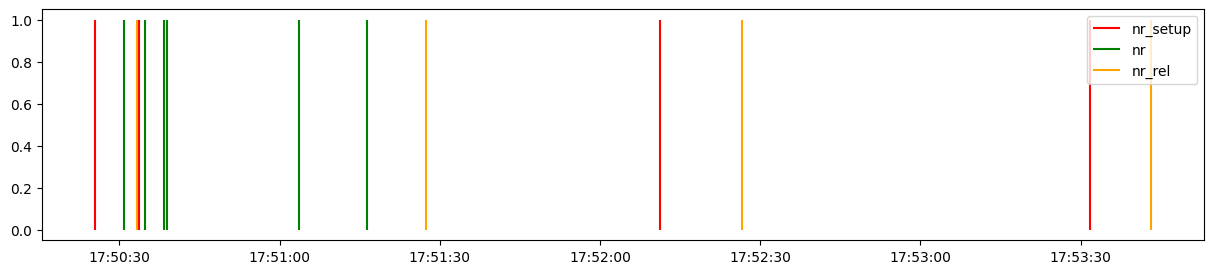

In [19]:
ho_type = ['nr_setup','nr', 'nr_rel']
# time_range = [dt.datetime(2022, 9, 7, 17, 52, 10), dt.datetime(2022, 9, 7, 17, 52, 25)]
time_range = None
x.draw_ho_event(ho_type=ho_type, x_lim=time_range)

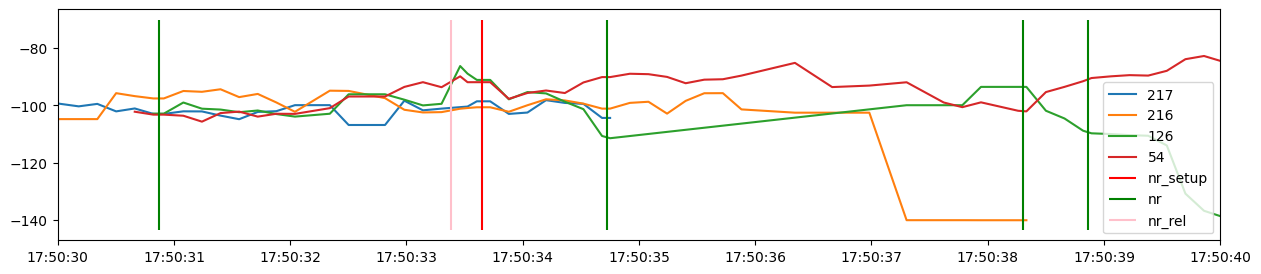

In [20]:
pci_list = ['217','216','126','54']
time_range = [dt.datetime(2022, 9, 7, 17, 50, 30), dt.datetime(2022, 9, 7, 17, 50, 40)]
# time_range = None
# rsrp_range = [-100, -80]
rsrp_range = None
show_ho = ['nr_setup', 'nr', 'nr_rel']
# show_ho = []
x.draw_pci_rsrp(pci_list, x_lim=time_range, y_lim=rsrp_range, show_ho=show_ho)